In [1]:
import librosa
import numpy as np

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [2]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
generalSoundPath = 'Audio-Classification/General-Sounds/'
legalVoicePath = 'Audio-Classification/User-Voices/Legal-Voices/'
illegalVoicePath = 'Audio-Classification/User-Voices/Illegal-Voices/'

features = []

for dirpath, dirnames, filenames in os.walk(generalSoundPath):
    for filename in filenames:
        file_name = os.path.join(dirpath, filename)
        
        class_label = 'General Sound'
        data = extract_features(file_name)

        features.append([data, class_label])
        
for dirpath, dirnames, filenames in os.walk(legalVoicePath):
    for filename in filenames:
        file_name = os.path.join(dirpath, filename)
        
        class_label = 'Legal Voice'
        data = extract_features(file_name)

        features.append([data, class_label])
        
for dirpath, dirnames, filenames in os.walk(illegalVoicePath):
    for filename in filenames:
        file_name = os.path.join(dirpath, filename)
        
        class_label = 'Illegal Voice'
        data = extract_features(file_name)

        features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from', len(featuresdf), 'files')

Finished feature extraction from 5030 files


In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [4]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [5]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [6]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [7]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 7

In [8]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
126/126 [==============================] - 3s 4ms/step - loss: 10.2937 - accuracy: 0.4448 - val_loss: 0.8924 - val_accuracy: 0.5795

Epoch 00001: val_loss improved from inf to 0.89241, saving model to saved_models\weights.best.basic_mlp.hdf5
Epoch 2/100
126/126 [==============================] - 1s 5ms/step - loss: 2.0766 - accuracy: 0.5209 - val_loss: 0.9206 - val_accuracy: 0.5716

Epoch 00002: val_loss did not improve from 0.89241
Epoch 3/100
126/126 [==============================] - 1s 5ms/step - loss: 1.0930 - accuracy: 0.5621 - val_loss: 0.8822 - val_accuracy: 0.6620

Epoch 00003: val_loss improved from 0.89241 to 0.88222, saving model to saved_models\weights.best.basic_mlp.hdf5
Epoch 4/100
126/126 [==============================] - 1s 5ms/step - loss: 0.9515 - accuracy: 0.5815 - val_loss: 0.8384 - val_accuracy: 0.7336

Epoch 00004: val_loss improved from 0.88222 to 0.83837, saving model to saved_models\weights.best.basic_mlp.hdf5
Epoch 5/100
126/126 [================


Epoch 00035: val_loss did not improve from 0.21897
Epoch 36/100
126/126 [==============================] - 1s 7ms/step - loss: 0.2554 - accuracy: 0.8971 - val_loss: 0.2013 - val_accuracy: 0.9394

Epoch 00036: val_loss improved from 0.21897 to 0.20131, saving model to saved_models\weights.best.basic_mlp.hdf5
Epoch 37/100
126/126 [==============================] - 1s 7ms/step - loss: 0.2530 - accuracy: 0.9063 - val_loss: 0.2181 - val_accuracy: 0.9274

Epoch 00037: val_loss did not improve from 0.20131
Epoch 38/100
126/126 [==============================] - 1s 7ms/step - loss: 0.2618 - accuracy: 0.8979 - val_loss: 0.2060 - val_accuracy: 0.9354

Epoch 00038: val_loss did not improve from 0.20131
Epoch 39/100
126/126 [==============================] - 1s 6ms/step - loss: 0.2567 - accuracy: 0.9001 - val_loss: 0.2237 - val_accuracy: 0.9294

Epoch 00039: val_loss did not improve from 0.20131
Epoch 40/100
126/126 [==============================] - 1s 7ms/step - loss: 0.2456 - accuracy: 0.9056 

126/126 [==============================] - 1s 7ms/step - loss: 0.1742 - accuracy: 0.9349 - val_loss: 0.1919 - val_accuracy: 0.9404

Epoch 00075: val_loss did not improve from 0.17652
Epoch 76/100
126/126 [==============================] - 1s 8ms/step - loss: 0.1634 - accuracy: 0.9361 - val_loss: 0.2017 - val_accuracy: 0.9384

Epoch 00076: val_loss did not improve from 0.17652
Epoch 77/100
126/126 [==============================] - 1s 7ms/step - loss: 0.1628 - accuracy: 0.9418 - val_loss: 0.2144 - val_accuracy: 0.9324

Epoch 00077: val_loss did not improve from 0.17652
Epoch 78/100
126/126 [==============================] - 1s 7ms/step - loss: 0.1553 - accuracy: 0.9416 - val_loss: 0.2122 - val_accuracy: 0.9384

Epoch 00078: val_loss did not improve from 0.17652
Epoch 79/100
126/126 [==============================] - 1s 7ms/step - loss: 0.1497 - accuracy: 0.9426 - val_loss: 0.1989 - val_accuracy: 0.9374

Epoch 00079: val_loss did not improve from 0.17652
Epoch 80/100
126/126 [===========

C:\Users\user\anaconda3\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


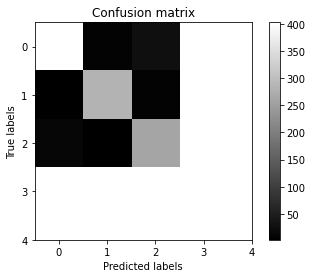

In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict_classes(x_test)
confusion_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.gray)
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(5)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

In [9]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9798707962036133
Testing Accuracy:  0.9443339705467224


In [10]:
def print_prediction(file_name):
    prediction_feature = np.array([extract_features(file_name)])

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [34]:
filename = 'V-YT-PSY-006051.wav'
# Legal
print_prediction(filename)

The predicted class is: General Sound 

General Sound 		 :  0.67666989564895629882812500000000
Illegal Voice 		 :  0.08893262594938278198242187500000
Legal Voice 		 :  0.23439744114875793457031250000000
